In [15]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os,glob
from sklearn.utils import shuffle
############### INPUT RGB IMAGE #######################
#Using opencv to read images may bemore robust compared to using skimage
#but need to remember to convert BGR to RGB.
#Also, convert to float later on and normalize to between 0 and 1.

#Image downloaded from:
#https://pbs.twimg.com/media/C1MkrgQWQAASbdz.jpg
def stain_norm(img,Io = 240, alpha=1,beta=0.15):
    '''
    REFERENCE : http://wwwx.cs.unc.edu/~mn/sites/default/files/macenko2009.pdf
    Io : Transmitted light intensity, Normalizing factor for image intensities (default : 240)
    alpha : As recommend in the paper. tolerance for the pseudo-min and pseudo-max (default: 1)
    beta : As recommended in the paper. OD threshold for transparent pixels (default: 0.15)
    '''
    
    ######## Step 1: Convert RGB to OD ###################
    ## reference H&E OD matrix.
    #Can be updated if you know the best values for your image. 
    #Otherwise use the following default values. 
    #Read the above referenced papers on this topic. 
    HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
    ### reference maximum stain concentrations for H&E
    maxCRef = np.array([1.9705, 1.0308])

    # extract the height, width and num of channels of image
    h, w, c = img.shape

    # reshape image to multiple rows and 3 columns.
    #Num of rows depends on the image size (wxh)
    img = img.reshape((-1,3))

    OD = -np.log10((img.astype(np.float)+1)/Io) #Use this for opencv imread
    #Add 1 in case any pixels in the image have a value of 0 (log 0 is indeterminate)
    
    ############ Step 2: Remove data with OD intensity less than β ############
    # remove transparent pixels (clear region with no tissue)
    ODhat = OD[~np.any(OD < beta, axis=1)] #Returns an array where OD values are above beta
    #Check by printing ODhat.min()

    ############# Step 3: Calculate SVD on the OD tuples ######################
    #Estimate covariance matrix of ODhat (transposed)
    # and then compute eigen values & eigenvectors.
    eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))


    ######## Step 4: Create plane from the SVD directions with two largest values ######
    #project on the plane spanned by the eigenvectors corresponding to the two 
    # largest eigenvalues    
    That = ODhat.dot(eigvecs[:,1:3]) #Dot product

    ############### Step 5: Project data onto the plane, and normalize to unit length ###########
    ############## Step 6: Calculate angle of each point wrt the first SVD direction ########
    #find the min and max vectors and project back to OD space
    phi = np.arctan2(That[:,1],That[:,0])

    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100-alpha)

    vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)


    # a heuristic to make the vector corresponding to hematoxylin first and the 
    # one corresponding to eosin second
    if vMin[0] > vMax[0]:    
        HE = np.array((vMin[:,0], vMax[:,0])).T

    else:
        HE = np.array((vMax[:,0], vMin[:,0])).T


    # rows correspond to channels (RGB), columns to OD values
    Y = np.reshape(OD, (-1, 3)).T

    # determine concentrations of the individual stains
    C = np.linalg.lstsq(HE,Y, rcond=None)[0]

    # normalize stain concentrations
    maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
    tmp = np.divide(maxC,maxCRef)
    C2 = np.divide(C,tmp[:, np.newaxis])

    ###### Step 8: Convert extreme values back to OD space
    # recreate the normalized image using reference mixing matrix 

    Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
    Inorm[Inorm>255] = 254
    Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)  
    return Inorm    
    


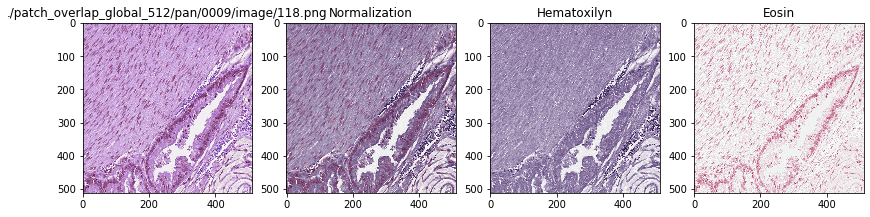

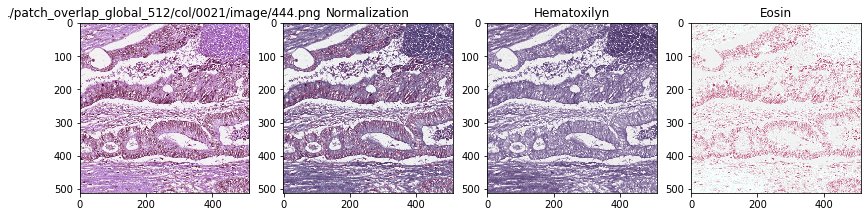

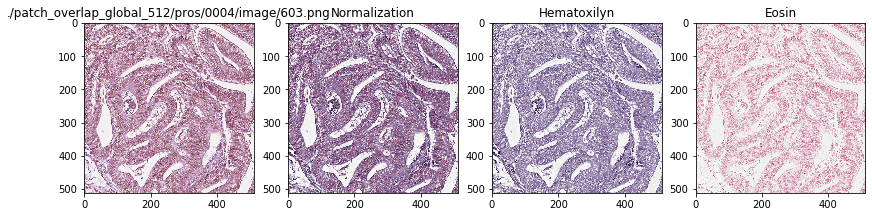

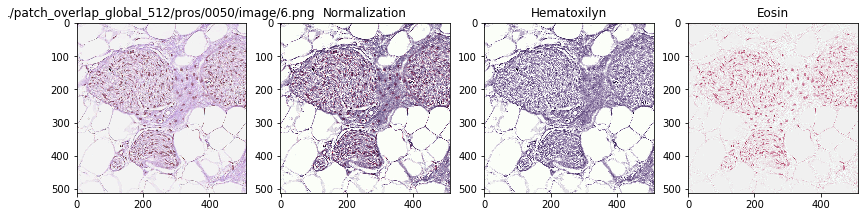

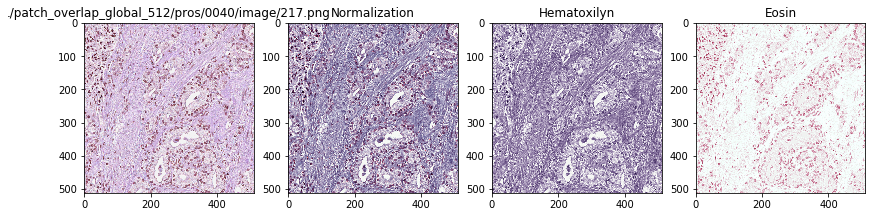

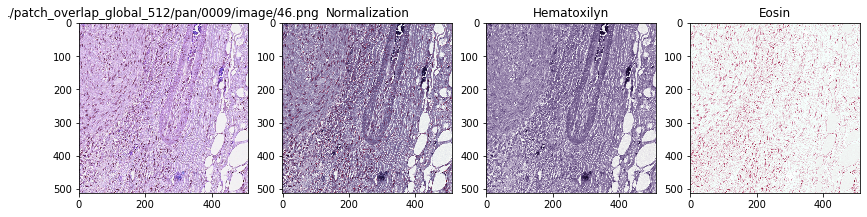

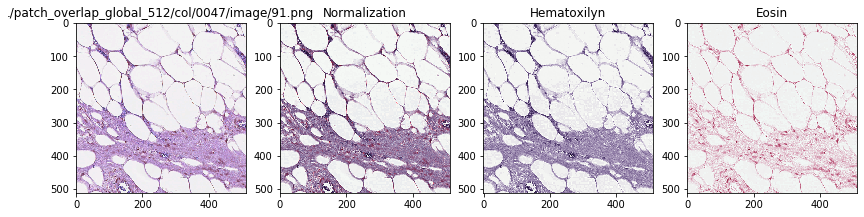

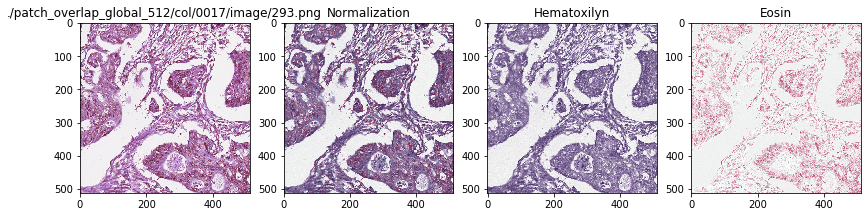

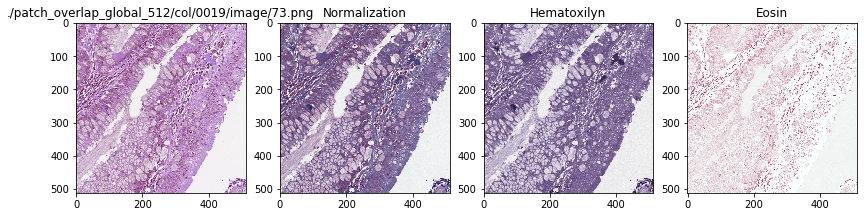

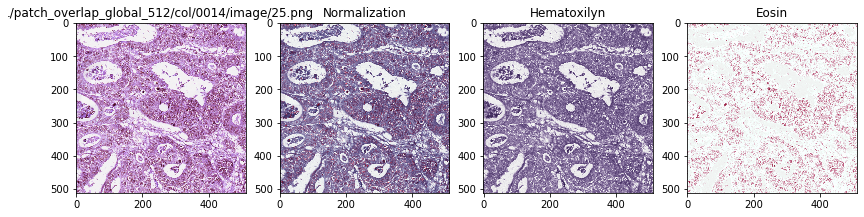

In [19]:
for fpath in shuffle(glob.glob('./patch_overlap_global_512/*/*/image/*.png'),random_state=311)[:10]:
    
    org = cv.imread(fpath, 1)
    img = org.copy()
    #img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    Io = 240 # Transmitted light intensity, Normalizing factor for image intensities
    alpha = 1  #As recommend in the paper. tolerance for the pseudo-min and pseudo-max (default: 1)
    beta = 0.15 #As recommended in the paper. OD threshold for transparent pixels (default: 0.15)


    ######## Step 1: Convert RGB to OD ###################
    ## reference H&E OD matrix.
    #Can be updated if you know the best values for your image. 
    #Otherwise use the following default values. 
    #Read the above referenced papers on this topic. 
    HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
    ### reference maximum stain concentrations for H&E
    maxCRef = np.array([1.9705, 1.0308])


    # extract the height, width and num of channels of image
    h, w, c = img.shape

    # reshape image to multiple rows and 3 columns.
    #Num of rows depends on the image size (wxh)
    img = img.reshape((-1,3))

    # calculate optical density
    # OD = −log10(I)  
    #OD = -np.log10(img+0.004)  #Use this when reading images with skimage
    #Adding 0.004 just to avoid log of zero. 

    OD = -np.log10((img.astype(np.float)+1)/Io) #Use this for opencv imread
    #Add 1 in case any pixels in the image have a value of 0 (log 0 is indeterminate)


    """
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(img[:,0],img[:,1],img[:,2])
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(OD[:,0],OD[:,1],OD[:,2])
    plt.show()
    """

    ############ Step 2: Remove data with OD intensity less than β ############
    # remove transparent pixels (clear region with no tissue)
    ODhat = OD[~np.any(OD < beta, axis=1)] #Returns an array where OD values are above beta
    #Check by printing ODhat.min()

    ############# Step 3: Calculate SVD on the OD tuples ######################
    #Estimate covariance matrix of ODhat (transposed)
    # and then compute eigen values & eigenvectors.
    eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))


    ######## Step 4: Create plane from the SVD directions with two largest values ######
    #project on the plane spanned by the eigenvectors corresponding to the two 
    # largest eigenvalues    
    That = ODhat.dot(eigvecs[:,1:3]) #Dot product

    ############### Step 5: Project data onto the plane, and normalize to unit length ###########
    ############## Step 6: Calculate angle of each point wrt the first SVD direction ########
    #find the min and max vectors and project back to OD space
    phi = np.arctan2(That[:,1],That[:,0])

    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100-alpha)

    vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)


    # a heuristic to make the vector corresponding to hematoxylin first and the 
    # one corresponding to eosin second
    if vMin[0] > vMax[0]:    
        HE = np.array((vMin[:,0], vMax[:,0])).T

    else:
        HE = np.array((vMax[:,0], vMin[:,0])).T


    # rows correspond to channels (RGB), columns to OD values
    Y = np.reshape(OD, (-1, 3)).T

    # determine concentrations of the individual stains
    C = np.linalg.lstsq(HE,Y, rcond=None)[0]

    # normalize stain concentrations
    maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
    tmp = np.divide(maxC,maxCRef)
    C2 = np.divide(C,tmp[:, np.newaxis])

    ###### Step 8: Convert extreme values back to OD space
    # recreate the normalized image using reference mixing matrix 

    Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
    Inorm[Inorm>255] = 254
    Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)  

    # Separating H and E components

    H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
    H[H>255] = 254
    H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)

    E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
    E[E>255] = 254
    E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)


    plt.figure(figsize = (14,10)); 
    plt.subplot(1,4,1); plt.title(fpath); plt.imshow(org)
    plt.subplot(1,4,2); plt.title('Normalization'); plt.imshow(Inorm)
    plt.subplot(1,4,3); plt.title('Hematoxilyn'); plt.imshow(H)
    plt.subplot(1,4,4); plt.title('Eosin'); plt.imshow(E)
    '''
    plt.imsave("HnE_normalized.jpg", Inorm)
    plt.imsave("HnE_separated_H.jpg", H)
    plt.imsave("HnE_separated_E.jpg", E)
    '''

In [18]:
t = stain_norm(org)